In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.dataloader import *
from utils.model import *

In [3]:
data_train = pd.read_csv('./data/LB_train.csv')
data_validation = pd.read_csv('./data/LB_validation.csv')
data_test = pd.read_csv('./data/LB_test.csv')

In [4]:
resolution = 5

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

/home/anupkumar/egalaxy/birdl/BirdDL/utils/dataloader.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_new = data_new.append(traj, ignore_index=True)
/home/anupkumar/egalaxy/birdl/BirdDL/utils/dataloader.py:65: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  traj['gaps'] = [np.mean(1*t.gaps[i:i+resolution]) for i in range(len(t)) if i%resolution==0]
/home/anupkumar/egalaxy/birdl/BirdDL/utils/dataloader.py:66: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `s

In [145]:
'''class GalaxyTrajDataSet():
    def __init__(self,  df, window, variable, transform=None):
        self.df = df.set_index(np.arange(len(df))) #reorder idx
        self.window = window
        self.var = variable
        self.start_idx = np.where([self.df.trip[i]==self.df.trip[i+self.window-1] for i in range(len(self.df)-self.window+1)])[0]
        self.transform = transform

    def __len__(self):
        return len(self.start_idx)

    def __getitem__(self, idx):
        i = self.start_idx[idx]
        # select variable of interest
        traj = self.df.loc[i:i+self.window-1, self.var]
        traj = np.array(traj).T
        dive = self.df.loc[i:i+self.window-1, 'dive']
        dive = np.array(dive)
        sample = (traj, dive)
        if self.transform:
            sample = self.transform(sample)
        print(sample[0].shape, sample[1].shape)
        
        return sample'''

In [146]:
'''def create_mat(data_set):
    d_features = list()
    d_labels = list()
    for i in range(len(data_set.start_idx)):
        row = data_set.__getitem__(i)
        print(row[0].shape, row[1].shape)
        d_features.append(row[0].numpy())
        d_labels.append(row[1].numpy())
    d_features = np.array(d_features)
    d_labels = np.array(d_labels)
    print(d_features.shape)
    print(d_labels.shape)
    return d_features, d_labels'''

In [6]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5

class TrajDataSet_new():
    def __init__(self,  df, window, variable, transform=None):
        self.df = df.set_index(np.arange(len(df))) #reorder idx
        self.window = window
        self.var = variable
        self.start_idx = np.where([self.df.trip[i]==self.df.trip[i+self.window-1] for i in range(len(self.df)-self.window+1)])[0]
        self.transform = transform

    def __len__(self):
        return len(self.start_idx)

    def __getitem__(self, idx):
        i = self.start_idx[idx]
        # select variable of interest
        traj = self.df.loc[i:i+self.window-1, self.var]
        traj = np.array(traj).T
        dive = self.df.loc[i:i+self.window-1, 'dive']
        dive = np.array(dive)
        sample = (traj, dive)
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    
def create_mat(data_set):
    d_features = list()
    d_labels = list()
    for i in range(len(data_set.start_idx)):
        row = data_set.__getitem__(i)
        #print(row[0].shape, row[1].shape)
        d_features.append(row[0].numpy())
        d_labels.append(row[1].numpy())
    d_features = np.array(d_features)
    d_labels = np.array(d_labels)
    print(d_features.shape)
    print(d_labels.shape)
    return d_features, d_labels

train_set = TrajDataSet_new(train, window, variable, transform=ToTensor())
tr_features, tr_labels = create_mat(train_set)

val_set = TrajDataSet_new(val, window, variable, transform=ToTensor())
val_features, val_labels = create_mat(val_set)

(66502, 3, 20)
(66502, 20)
(43063, 3, 20)
(43063, 20)


In [ ]:
# Oversample positive samples
'''over_pos_samples = list()
over_pos_labels = list()
for i in range(tr_labels.shape[0]):
    if tr_labels_sq[i] == 1:
        over_pos_samples.append(tr_features[i])
        over_pos_labels.append(tr_labels_sq[i])
        
over_pos_samples = np.array(over_pos_samples)

oversample_factor = 5

re_over_pos_sample = np.repeat(over_pos_samples, oversample_factor, axis=0)
re_over_pos_labels = np.repeat(over_pos_labels, oversample_factor, axis=0)
re_over_pos_sample.shape, re_over_pos_labels.shape


oversample_tr_features = np.concatenate((tr_features, re_over_pos_sample), axis=0)
oversample_tr_labels = np.concatenate((tr_labels_sq, re_over_pos_labels), axis=0)
oversample_tr_features.shape, oversample_tr_labels.shape
idx = np.random.permutation(oversample_tr_features.shape[0])
oversample_tr_features, oversample_tr_labels = oversample_tr_features[idx], oversample_tr_labels[idx]
oversample_tr_features.shape, oversample_tr_labels.shape'''

In [64]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(8, kernel_size=5, padding='causal', activation='relu', strides=1, input_shape=(3, 20)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(16, kernel_size=5, padding='causal', activation='relu', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(32, kernel_size=5, padding='causal', activation='relu', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(20, kernel_size=5, padding='causal', strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy_2'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')]
)

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_80 (Conv1D)          (None, 3, 8)              808       
                                                                 
 batch_normalization_12 (Bat  (None, 3, 8)             32        
 chNormalization)                                                
                                                                 
 conv1d_81 (Conv1D)          (None, 3, 16)             656       
                                                                 
 batch_normalization_13 (Bat  (None, 3, 16)            64        
 chNormalization)                                                
                                                                 
 conv1d_82 (Conv1D)          (None, 3, 32)             2592      
                                                                 
 batch_normalization_14 (Bat  (None, 3, 32)          

In [66]:
model.fit(tr_features, tr_labels, batch_size=32, validation_data=(val_features, val_labels), epochs=10, shuffle=True)

Epoch 1/10
2079/2079 [==============================] - 7s 3ms/step - loss: 0.2924 - accuracy: 0.0843 - tp: 63.0000 - fp: 78.0000 - tn: 1172562.0000 - fn: 157337.0000 - accuracy_2: 0.8816 - precision: 0.4468 - recall: 4.0025e-04 - auc: 0.8012 - prc: 0.2789 - val_loss: 0.2983 - val_accuracy: 0.0576 - val_tp: 3.0000 - val_fp: 21.0000 - val_tn: 765859.0000 - val_fn: 95377.0000 - val_accuracy_2: 0.8892 - val_precision: 0.1250 - val_recall: 3.1453e-05 - val_auc: 0.7714 - val_prc: 0.2342
Epoch 2/10
2079/2079 [==============================] - 9s 4ms/step - loss: 0.2916 - accuracy: 0.0903 - tp: 149.0000 - fp: 177.0000 - tn: 1172463.0000 - fn: 157251.0000 - accuracy_2: 0.8816 - precision: 0.4571 - recall: 9.4663e-04 - auc: 0.8036 - prc: 0.2843 - val_loss: 0.3003 - val_accuracy: 0.4196 - val_tp: 0.0000e+00 - val_fp: 4.0000 - val_tn: 765876.0000 - val_fn: 95380.0000 - val_accuracy_2: 0.8893 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7689 - val_prc: 0.2335
Epoch 3/10
2079/2

In [67]:
te_set = TrajDataSet_new(test, window, variable, transform=ToTensor())
te_features, te_labels = create_mat(te_set)

(24797, 3, 20)
(24797, 20)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [68]:
te_pred = model.predict(te_features)

775/775 [==============================] - 1s 1ms/step


In [70]:
te_pred.shape

((24797, 20), (24797, 20))

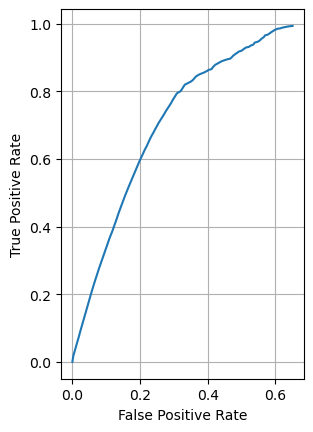

In [81]:
def plot_roc(input, target):
  # globally
  TP = []
  FP = []

  for tt in np.arange(0,1,0.001):
      all_estim = 1* (input > tt)
      true_positive = np.mean(all_estim[target == 1])
      true_negative = 1-np.mean(all_estim[target == 0])
      TP.append(true_positive)
      FP.append(1-true_negative)

  return (np.array(FP), np.array(TP))

roc_x, roc_y = plot_roc(te_pred, te_labels)

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
plt.grid(True)
plt.show()

In [83]:
print(te_labels.shape, te_pred.shape)
conf_mat = tf.math.confusion_matrix(te_labels, te_pred)
conf_mat

(24797, 20) (24797, 20)


InvalidArgumentError: {{function_node __wrapped__ScatterNd_device_/job:localhost/replica:0/task:0/device:CPU:0}} Dimensions [0,2) of indices[shape=[24797,2,20]] must match dimensions [0,2) of updates[shape=[24797,20]] [Op:ScatterNd]

In [28]:
'''class CNNet(nn.Module):
    def __init__(self, nb_feature):
        super(CNNet, self).__init__()

        self.name = 'CNNet'
        self.nb_feature = nb_feature

        self.cnn = nn.Sequential(
            nn.Conv1d(self.nb_feature, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Conv1d(8, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Conv1d(16, 32, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, 1, kernel_size = 5, stride = 1, padding = 2, dilation = 1)
        )

    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze()
    
#model = CNNet(len(variable))

class Lightning(LightningModule):
    def __init__(self, model, weight):
        super().__init__()
        self.model = model
        self.lr = 1e-3
        self.register_buffer("weight", torch.FloatTensor([weight])) 

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x,y = batch
        
        out = self.forward(x)
        print(x.shape, y.shape, out.shape)
        loss = nn.functional.binary_cross_entropy_with_logits(out, y, pos_weight = self.weight)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x,y = batch
        out = self.forward(x)
        loss = nn.functional.binary_cross_entropy_with_logits(out, y, pos_weight = self.weight)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x,y = batch
        out = self.forward(x)
        loss = nn.functional.binary_cross_entropy_with_logits(out, y, pos_weight = self.weight)
        # self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet_new(val, window, variable, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'GalaxyLB_'+model.model.name+'_'+ str(resolution)+ 's--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = True)

trainer.fit(model, train_loader, val_loader)'''

'class CNNet(nn.Module):\n    def __init__(self, nb_feature):\n        super(CNNet, self).__init__()\n\n        self.name = \'CNNet\'\n        self.nb_feature = nb_feature\n\n        self.cnn = nn.Sequential(\n            nn.Conv1d(self.nb_feature, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),\n            nn.BatchNorm1d(8),\n            nn.ReLU(),\n\n            nn.Conv1d(8, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),\n            nn.BatchNorm1d(16),\n            nn.ReLU(),\n\n            nn.Conv1d(16, 32, kernel_size = 5, stride = 1, padding = 2, dilation = 1),\n            nn.BatchNorm1d(32),\n            nn.ReLU(),\n\n            nn.Conv1d(32, 1, kernel_size = 5, stride = 1, padding = 2, dilation = 1)\n        )\n\n    def forward(self, x):\n        out = self.cnn(x)\n        return out.squeeze()\n    \n#model = CNNet(len(variable))\n\nclass Lightning(LightningModule):\n    def __init__(self, model, weight):\n        super().__init__()\n        self.m

In [12]:
tr_params = model.train(tr_features, tr_labels)

TypeError: Module.train() takes from 1 to 2 positional arguments but 3 were given

{'0': 58592, '1': 7870}


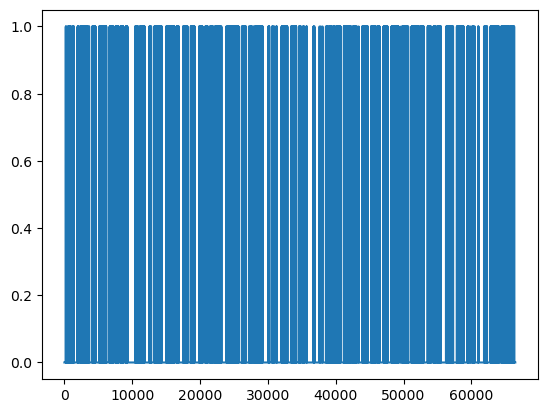

In [78]:
tr_labels_sq = tr_labels.squeeze()
tr_labels_sq_frq = dict()
for i in range(tr_labels_sq.shape[0]):
    if tr_labels_sq[i] == 0.0:
        if "0" not in tr_labels_sq_frq:
            tr_labels_sq_frq["0"] = 0
        tr_labels_sq_frq["0"] += 1
    else:
        if "1" not in tr_labels_sq_frq:
            tr_labels_sq_frq["1"] = 0
        tr_labels_sq_frq["1"] += 1 
    
print(tr_labels_sq_frq)
plt.plot(list(np.arange(0, 66462)), list(tr_labels.squeeze()))
plt.show()

In [88]:
# Oversample positive samples
over_pos_samples = list()
over_pos_labels = list()
for i in range(tr_labels_sq.shape[0]):
    if tr_labels_sq[i] == 1:
        over_pos_samples.append(tr_features[i])
        over_pos_labels.append(tr_labels_sq[i])
        
over_pos_samples = np.array(over_pos_samples)

oversample_factor = 5

re_over_pos_sample = np.repeat(over_pos_samples, oversample_factor, axis=0)
re_over_pos_labels = np.repeat(over_pos_labels, oversample_factor, axis=0)
re_over_pos_sample.shape, re_over_pos_labels.shape

((39350, 3, 21), (39350,))

In [90]:
oversample_tr_features = np.concatenate((tr_features, re_over_pos_sample), axis=0)
oversample_tr_labels = np.concatenate((tr_labels_sq, re_over_pos_labels), axis=0)
oversample_tr_features.shape, oversample_tr_labels.shape

((105812, 3, 21), (105812,))

In [92]:
oversample_tr_features = np.concatenate((tr_features, re_over_pos_sample), axis=0)
oversample_tr_labels = np.concatenate((tr_labels_sq, re_over_pos_labels), axis=0)
oversample_tr_features.shape, oversample_tr_labels.shape
idx = np.random.permutation(oversample_tr_features.shape[0])
oversample_tr_features, oversample_tr_labels = oversample_tr_features[idx], oversample_tr_labels[idx]
oversample_tr_features.shape, oversample_tr_labels.shape

((105812, 3, 21), (105812,))

In [44]:
import tensorflow as tf

2022-10-19 12:36:09.184064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [141]:
'''
self.cnn = nn.Sequential(
    nn.Conv1d(self.nb_feature, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
    nn.BatchNorm1d(8),
    nn.ReLU(),

    nn.Conv1d(8, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
    nn.BatchNorm1d(16),
    nn.ReLU(),

    nn.Conv1d(16, 32, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
    nn.BatchNorm1d(32),
    nn.ReLU(),

    nn.Conv1d(32, 1, kernel_size = 5, stride = 1, padding = 2, dilation = 1)
)
'''

'''model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(8, kernel_size=5, padding='same', activation='relu', strides=1, input_shape=(3, 21)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(16, kernel_size=5, padding='same', activation='relu', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(32, kernel_size=5, padding='same', activation='relu', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(1, kernel_size=5, padding='same', strides=1),
])

model.compile(
    optimizer='adam',
    loss= 'binary_crossentropy', #tf.keras.losses.BinaryCrossentropy(from_logits=False), #'binary_crossentropy',
    metrics=['accuracy']
)

model.summary()'''

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def create_model():
    
    inp = tf.keras.Input(shape=(3, 21))
    conv1d_1 = tf.keras.layers.Conv1D(8, kernel_size=5, padding='same', activation='relu', strides=1)
    conv1d_2 = tf.keras.layers.Conv1D(16, kernel_size=5, padding='same', activation='relu', strides=1)
    conv1d_3 = tf.keras.layers.Conv1D(32, kernel_size=5, padding='same', activation='relu', strides=1)
    conv1d_4 = tf.keras.layers.Conv1D(1, kernel_size=5, padding='same', strides=1)
    #output_layer = tf.keras.layers.Dense(1)
    
    x = conv1d_1(inp)
    x = conv1d_2(x)
    x = conv1d_3(x)
    x = conv1d_4(x)
    #conv_out = output_layer(x)
    model = tf.keras.Model([inp], [x])
    return model
    
create_model()


In [129]:
model.fit(oversample_tr_features, oversample_tr_labels, batch_size=32, validation_data=(validation_features, validation_labels), epochs=5)

Epoch 1/5
3307/3307 [==============================] - 11s 3ms/step - loss: 4.0804 - accuracy: 0.5134 - val_loss: 1.5913 - val_accuracy: 0.6213
Epoch 2/5
3307/3307 [==============================] - 13s 4ms/step - loss: 2.5373 - accuracy: 0.5147 - val_loss: 1.4616 - val_accuracy: 0.6220
Epoch 3/5
3307/3307 [==============================] - 13s 4ms/step - loss: 1.6962 - accuracy: 0.5140 - val_loss: 0.8352 - val_accuracy: 0.6822
Epoch 4/5
3307/3307 [==============================] - 13s 4ms/step - loss: 0.8600 - accuracy: 0.5261 - val_loss: 0.6156 - val_accuracy: 0.8048
Epoch 5/5
3307/3307 [==============================] - 14s 4ms/step - loss: 0.6945 - accuracy: 0.5407 - val_loss: 0.6388 - val_accuracy: 0.8168


In [131]:
test_set = GalaxyTrajDataSet(test, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
te_features, te_labels = create_mat(test_set)

(24782, 3, 21)
(24782, 1)


In [133]:
te_pred = model.predict(te_features)

775/775 [==============================] - 1s 1ms/step


In [135]:
te_pred.shape

(24782, 3, 1)

In [136]:
te_pred[0]

array([[0.43524718],
       [0.4750998 ],
       [0.44796276]], dtype=float32)

In [137]:
te_labels[0]

array([0.], dtype=float32)